# Redes Neuronales Profundas

En este cuaderno (Laboratorio 3) vamos a explorar la estructura e implementacion de redes neuronales profundas, como se ha visto en las lecciones del curso [Deep Learning y Redes Neuronales](https://).

## **Objetivos**

* Implementar una red neuronal profunda utilizando python y numpy.
* Entrenar el modelo para el dataset de cancer seno.

Para comenzar importaremos las librerias, en este caso utilizaremos sklearn para cargar el dataset y ademas de esto para realizar la division entre datos de entrenamiento y prueba.

In [1145]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Ahora vamos a cargar el dataset de cancer de seno y vamos a explorar sus dimensiones, caracteristicas de entrada y etiquetas de salida.

In [1146]:
data = datasets.load_breast_cancer()

X = data.data
Y = data.target
n_x = X.shape[1]

print("El tamaño de X es: " + str(X.shape)) # Tamaño de las variables de entrada
print("El tamaño de Y es: " + str(Y.shape)) # Tamañano de las etiquetas
print("\n")
print("Caracteristicas de entrada: " + str(data.feature_names))
print("\n")
print("Etiquetas: " + str(data.target_names))

El tamaño de X es: (569, 30)
El tamaño de Y es: (569,)


Caracteristicas de entrada: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Etiquetas: ['malignant' 'benign']


Luego dividimos los datos en datos de entrenamiento y prueba.

In [1147]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

print ("Tamaño de X_train: " + str(X_train.shape))
print ("Tamaño de Y_train: " + str(Y_train.shape))
print ("Tamaño de X_test: " + str(X_test.shape))
print ("Tamaño de Y_test: " + str(Y_test.shape))

Tamaño de X_train: (455, 30)
Tamaño de Y_train: (455,)
Tamaño de X_test: (114, 30)
Tamaño de Y_test: (114,)


Para cumplir las dimensiones definidas en nuestras ecuaciones, vamos a trasponer las entradas y a convertir el vector de salida en un vector fila.

In [1148]:
X_train, X_test, Y_train, Y_test = X_train.T, X_test.T, Y_train.reshape((1,-1)), Y_test.reshape((1,-1))

print ("Tamaño de X_train: " + str(X_train.shape))
print ("Tamaño de Y_train: " + str(Y_train.shape))
print ("Tamaño de X_test: " + str(X_test.shape))
print ("Tamaño de Y_test: " + str(Y_test.shape))

Tamaño de X_train: (30, 455)
Tamaño de Y_train: (1, 455)
Tamaño de X_test: (30, 114)
Tamaño de Y_test: (1, 114)


Ya teniendo nuestros datos vamos a definir nuestro modelo de red neuronal profunda, antes de programar el codigo, es conveniente que repasemos rapidamente las dimensiones de los diferentes elementos y las ecuaciones principales del modelo.

**Forward Propagation**

X = A^{[0]}

$Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}$

$A^{[l]} = relu(Z^{[l]})$

Para la capa de salida utilizamos la función de activación sigmoidal:

$A^{[L]} = \hat{Y} = \sigma(Z^{[L]}) = \frac{1}{1 + e^{-Z^{[L]}}}$

**Backpropagation**

Recordemos la función de costo:

$L(a, y) = -(y\log{(a)} + (1 - y)\log{(1 - a)})$

$J(W, b) = \frac{1}{m} \sum_{i=1}^m L(a^{}, y^{})$

Ahora los gradientes para los pesos y biases son:

$\frac{\partial L}{\partial Z^{[L]}} = dZ^{[L]} = A^{[L]} - Y$

$\frac{\partial L}{\partial Z^{[l]}} = dZ^{[l]} = W^{[l]T}dZ^{[l]}*g^{\prime}(Z^{[l]})$

$\frac{\partial J}{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]}A^{[l-1]T}$

$\frac{\partial J}{\partial b^{[l]}} = \frac{1}{m} \sum_{i=1}^m dZ_{ji}^{[l]}$

**Gradiente Descendente**

$W^{[l]} = W^{[l]} - \alpha \frac{\partial J}{\partial W^{[l]}}$

$b^{[l]} = b^{[l]} - \alpha \frac{\partial J}{\partial b^{[l]}}$

**Dimensiones de los diferentes elementos**

* X es ($n_x$, m)
* Y es (1, m)
* $W^{[l]}$ es ($n^{[l]}$, $n^{[l-1]}$)
* $b^{[l]}$ es ($n^{[l]}$, 1)
* $Z^{[l]}$ y $A^{[1]}$ son ($n^{[l]}$, m)

In [1149]:
class DeepNeuralNetwork:
    
    # Constructor de la clase
    def __init__(self, input_dim, hidden_layers=[2]):
        self.layer_dims = [input_dim] + hidden_layers + [1]
        self.initialize_weights()

    # Inicializar pesos
    def initialize_weights(self):
    
        self.weights = [dict() for i in range(len(self.layer_dims) - 1)]
        for i in range(len(self.layer_dims) - 1):
            self.weights[i]["W"] = np.random.randn(self.layer_dims[i + 1], self.layer_dims[i])*0.01
            self.weights[i]["b"] = np.zeros((self.layer_dims[i + 1], 1))   

    # Forward Propagation
    def forward_propagation(self, X):

        cache = [dict() for i in range(len(self.layer_dims) - 1)]

        Z = 0  
        A = X

        for i in range(len(self.layer_dims) - 2):

            cache[i]["A"] = A
            cache[i]["Z"] = Z

            Z = np.dot(self.weights[i]["W"], A) + self.weights[i]["b"]
            A = np.maximum(Z,0) # ReLu Activation

        cache[-1]["A"] = A
        cache[-1]["Z"] = Z

        Z = np.dot(self.weights[-1]["W"], A) + self.weights[-1]["b"]
        Y_hat = 1/(1 + np.exp(-Z)) 

        return Y_hat, cache

    # Propagacion hacia atras para encontrar los gradientes
    def backpropagation(self, m, error, cache):

        grads = [dict() for i in range(len(self.layer_dims) - 1)]

        dZ = error

        grads[-1]["W"] = (1./m)*np.dot(dZ, cache[-1]["A"].T)
        grads[-1]["b"] = (1./m)*np.sum(dZ, axis=1, keepdims=True)

        for i in reversed(range(1,len(self.layer_dims) - 1)):

            dg = (cache[i]["Z"] > 0).astype(float) # ReLu Gradient
            dZ = np.multiply(np.dot(self.weights[i]["W"].T, dZ), dg)

            grads[i-1]["W"] = (1./m)*np.dot(dZ, cache[i-1]["A"].T)
            grads[i-1]["b"] = (1./m)*np.sum(dZ, axis=1, keepdims=True)     

        return grads
    
    # Actualizar los pesos utilizando gradiente descendente
    def update_weights(self, grads, learning_rate):
    
        for i in range(len(self.layer_dims) - 1):
            for param in self.weights[i].keys():
        
                self.weights[i][param] = self.weights[i][param] - learning_rate*grads[i][param]

    # Entrenar el modelo
    def fit(self, X, Y, iters = 1000, learning_rate = 0.01):
        
        m = X.shape[1]
        cost = []

        for t in range(iters):

            Y_hat, cache = self.forward_propagation(X)

            error = Y_hat - Y
            cost.append(-(1./m)*(np.sum(Y*np.log(Y_hat) + (1 - Y)*np.log(1-Y_hat))))

            grads = self.backpropagation(m, error, cache)

            self.update_weights(grads, learning_rate)

        return cost

    # Funcion de prediccion
    def predict(self, X):

        Y_hat, _ = self.forward_propagation(X)

        return np.round(Y_hat)

Creamos el modelo.

In [1150]:
model = DeepNeuralNetwork(n_x, [4,4])

Entrenamos el modelo.

In [1151]:
cost = model.fit(X_train, Y_train, iters=10000, learning_rate=0.005)

Exactitud de entrenamiento = 0.9472527472527472
Exactitud de prueba = 0.9035087719298246


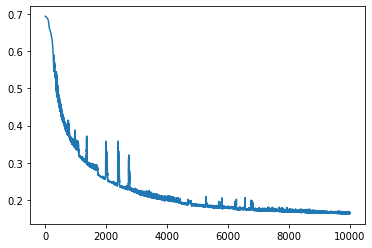

In [1152]:
train_predictions = model.predict(X_train)
train_acc = accuracy_score(Y_train.reshape((-1,)), train_predictions.reshape((-1,)))

test_predictions = model.predict(X_test)
test_acc = accuracy_score(Y_test.reshape((-1,)), test_predictions.reshape((-1,)))

print("Exactitud de entrenamiento = " + str(train_acc))
print("Exactitud de prueba = " + str(test_acc))

plt.plot(cost)